In [45]:
import math, random

import gym
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
ckpt_dir = './checkpoints_laplace'
def get_ckpt_names():
    ckpt_names = []
    files = os.listdir(ckpt_dir)
    files.sort()

    file_with_ext = []
    for foo in files:
        file_with_ext.append(ckpt_dir + '/' + foo)

    ckpt_names = sorted(file_with_ext,key=os.path.getctime)
    return ckpt_names

<h3>Use Cuda</h3>

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Double Deep Q Network</h2>

<h3>Synchronize current policy net and target net</h3>

In [23]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

<h2>Computing Temporal Difference Loss</h2>

In [24]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Testing

In [33]:
def plot_test(ckpt, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Test checkpoint %s. reward: %s' % (ckpt[-1], np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

<h1>Atari Environment</h1>

In [26]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [27]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [28]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

## Testing with Visualization

In [36]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [37]:
from scipy.ndimage import gaussian_laplace

In [43]:
# env_id = "CartPole-v0"
# No exploring, only playin to the model for Testing
epsilon=0
# done=False

def test(model):
    done=False
    model.eval()
    
    env = make_atari(env_id)
    env = wrap_deepmind(env)
    env = wrap_pytorch(env)
    
    state = env.reset()
    state = gaussian_laplace(state, sigma=3)
    
    testReward=0
    
    while not done:
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        state = gaussian_laplace(next_state, sigma=3)
        
        testReward += reward
    state = env.reset()
    if done:
        env.close()

    return testReward

## Run Results for Every Checkpoint for a graph

In [46]:
ckpt_names = get_ckpt_names()

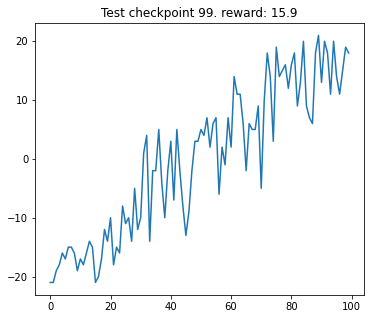

In [44]:
rewards = []
idx_arr = []
for idx,ckpt in enumerate(ckpt_names):
    if os.path.isfile(ckpt):
        load_ckpt = ckpt
        # Load the Model
        current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
        current_model.load_state_dict(torch.load(load_ckpt))

        if USE_CUDA:
            current_model = current_model.cuda()

        # run the loaded model, save the output
        r = test(current_model)

        rewards.append(r)
        idx_arr.append(idx)
        plot_test(idx_arr, rewards)

## 20 runs for 10k frames each

In [ ]:
numerical = []

recent_checkpoint = ckpt_dir + '/' +'1000000_DoubleDQN.ckpt'
for i in range(0,20):
    subset = []
    print("Sample {}".format(i))
    for frame in range(100):
        # Load the Model
        current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
        current_model.load_state_dict(torch.load(recent_checkpoint))
        if USE_CUDA:
            current_model = current_model.cuda()

        r = test(current_model)

        subset.append(r)
#         plot_test([frame], rewards)
    print("Data: {}".format(subset))
    numerical.append(subset)
    

Sample 0


c:\users\blake\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Data: [-21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0]
Sample 1


## Numerical analysis

#### Get average and median for each of 30 runs, and take mean of those means 

In [ ]:
# TODO